# FORNAX 3D Neutrino Spectra

Data taken from the HDF5 files available for download at [the Princeton group website](https://www.astro.princeton.edu/~burrows/nu-emissions.3d/data/).

In [9]:
from snewpy.neutrino import Flavor
from snewpy.models import SupernovaModel

from astropy import units as u

from glob import glob

import h5py
import numpy as np

from scipy.special import gamma, lpmv

import matplotlib as mpl
import matplotlib.pyplot as plt

In [10]:
mpl.rc('font', size=16)

## Model Class

Test class that inherits from the `SupernovaModel` abstract base class in `snewpy.models`.

In this implementation, we read in the spectra computed on a discrete energy grid with 12 energy bins (see the [documentation here](https://www.astro.princeton.edu/~burrows/nu-emissions.3d/)) and linearly interpolate to obtain a reasonably smooth spectrum.

In [30]:
class Fornax_2019_3D(SupernovaModel):
    """Model based 3D simulations from D. Vartanyan, A. Burrows, D. Radice, M. A. Skinner and J. Dolence,
    MNRAS 482(1):351, 2019. Data available at https://www.astro.princeton.edu/~burrows/nu-emissions.3d/.
    """

    def __init__(self, filename, cache_flux=False):
        """Initialize model.

        Parameters
        ----------
        filename : str
            Absolute or relative path to FITS file with model data.
        cache_flux : bool
            If true, pre-compute the flux on a fixed angular grid. Time and memory intensive!
        """
        # Set up model metadata.
        self.progenitor_mass = float(filename.split('_')[-1][:-4]) * u.Msun

        # Conversion of flavor to key name in the model HDF5 file.
        self._flavorkeys = { Flavor.NU_E : 'nu0',
                             Flavor.NU_E_BAR : 'nu1',
                             Flavor.NU_X : 'nu2',
                             Flavor.NU_X_BAR : 'nu2' }

        # Open HDF5 data file.
        self._h5file = h5py.File(filename, 'r')

        # Get grid of model times.
        self.time = self._h5file['nu0']['g0'].attrs['time'] * u.s
        
        # Retrieve grid.h5 file, get grid of phi and theata values.
        self.grid = h5py.File('../../models/Fornax_2019/grid.h5', 'r')
        self.phi = np.array(self.grid['phic'])
        self.theta = np.array(self.grid['thc'])
        self.dOmega = np.array(self.grid['dOmega'])
        
        # Temporary: reduce grid size by 4x in each dimension (16x fewer points).
        self.phic = self.phi[::4]
        self.thetac = self.theta[::4]
        
        if cache_flux:
            dE = self._h5file['nu0']['degroup'][()].astype(np.single)
            E = self._h5file['nu0']['egroup'][()].astype(np.single)

            nt, ne = E.shape
            nth, nph = len(thetac), len(phic)

            dLdE = np.zeros((nt, ne, nth, nph), dtype=np.single)

            # Loop over time bins.
            for i in range(nt):
                # Loop over energy bins.
                for j in range(ne):
                    dLdE_ij = 0.
                    # Sum over multipole moments.
                    for l in range(3):
                        for m in range(-l, l + 1):
                            Ylm = real_sph_harm(l,m)
                            dLdE_ij += self._h5file['nu0']['g{}'.format(j)]['l={} m={}'.format(l,m)][i] * Ylm[l][m]
                    dLdE[i][j] = dLdE_ij
            
            # To compute luminosity vs t, theta, phi:
            # np.sum(dLdE * dE[:,:,np.newaxis,np.newaxis], axis=1)
            

    def get_time(self):
        return self.time
    
    def fact(self, n):
        """
        Note: math.factorial returns an int, but we want to work only with floats
        """
        return gamma(n + 1.)
    
    def real_sph_harm(self, l, m, theta, phi):
        """
        Computes the orthonormalized real spherical harmonics Y_lm
        """
        if m < 0:
            norm = np.sqrt((2*l + 1.)/(2*np.pi)*self.fact(l + m)/self.fact(l - m))
            return norm * lpmv(-m, l, np.cos(theta)) * np.sin(-m*phi)
        elif m == 0:
            norm = np.sqrt((2*l + 1.)/(4*np.pi))
            return norm * lpmv(0, l, np.cos(theta)) * np.ones_like(phi)
        else:
            norm = np.sqrt((2*l + 1.)/(2*np.pi)*self.fact(l - m)/self.fact(l + m))
            return norm * lpmv(m, l, np.cos(theta)) * np.cos(m*phi)

    def get_initialspectra(self, t, E, theta, phi, interpolation='linear'):
        """Get neutrino spectra/luminosity curves after oscillation.

        Parameters
        ----------
        t : float
            Time to evaluate initial and oscillated spectra.
        E : float or ndarray
            Energies to evaluate the initial and oscillated spectra.
        theta : astropy.Quantity
            Zenith angle of the spectral emission.
        phi : astropy.Quantity
            Azimuth angle of the spectral emission.

        Returns
        -------
        initialspectra : dict
            Dictionary of model spectra, keyed by neutrino flavor.
        """
        initialspectra = {}
        
        # Make sure the input time uses the same units as the model time grid.
        # Convert input time to a time index.
        t = t.to(self.time.unit)
        j = (np.abs(t - self.time)).argmin()
        
        dE = self._h5file['nu0']['degroup'][j] 
        
#         # Store differential flux per energy, angle, and time, for each flavor.
#         dLdE_i = []
        
#         # Sum over energy bins.
#         for ebin in range(len(dE)):
#             dLdE_j = 0
#             # Sum over multipole moments.
#             for l in range(3):
#                 for m in range(-l, l + 1):
#                     Ylm = self.real_sph_harm(l, m, theta.to('radian').value, phi.to('radian').value)
#                     dLdE_j += self._h5file['nu0']['g{}'.format(ebin)]['l={} m={}'.format(l,m)][j] * Ylm
#             dLdE_i.append(dLdE_j)
            
        # Avoid "division by zero" in retrieval of the spectrum.
        E[E == 0] = np.finfo(float).eps * E.unit
        logE = np.log10(E.to('MeV').value)
        
        for flavor in Flavor:
            key = self._flavorkeys[flavor]
            
            # Store differential flux per energy, angle, and time.
            dLdE_i = []

            # Sum over energy bins.
            for ebin in range(len(dE)):
                dLdE_j = 0
                # Sum over multipole moments.
                for l in range(3):
                    for m in range(-l, l + 1):
                        Ylm = self.real_sph_harm(l, m, theta.to('radian').value, phi.to('radian').value)
                        dLdE_j += self._h5file['nu0']['g{}'.format(ebin)]['l={} m={}'.format(l,m)][j] * Ylm
                dLdE_i.append(dLdE_j)

            # Energy in units of MeV.
            _E = self._h5file[key]['egroup'][j]

            factor = 1e50*u.MeV
            if not flavor.is_electron:
                # Model flavors (internally) are nu_e, nu_e_bar, and nu_x, which stands
                # for nu_mu(_bar) and nu_tau(_bar), making the flux 4x higher than nu_e and nu_e_bar.
                # Since we separate NU_X and NU_X_BAR here, multiply by 2x, not 4x.
                factor *= 0.5

            # Linear interpolation in flux.
            if interpolation.lower() == 'linear':
                # Pad log(E) array with values where flux is fixed to zero.
                _logE = np.log10(_E)
                _dlogE = np.diff(_logE)
                _logEbins = np.insert(_logE, 0, np.log10(np.finfo(float).eps))
                _logEbins = np.append(_logEbins, _logE[-1] + _dlogE[-1])

                # Spectrum in units of 1e50 erg/s/MeV.
                # Pad with values where flux is fixed to zero.
                _dLdE = np.asarray([0.] + dLdE_i + [0.])
                initialspectra[flavor] = np.interp(logE, _logEbins, _dLdE) * factor

            elif interpolation.lower() == 'nearest':
                _logE = np.log10(_E)
                _dlogE = np.diff(_logE)[0]
                _logEbins = _logE - _dlogE
                _logEbins = np.concatenate((_logEbins, [_logE[-1] + _dlogE]))
                _Ebins = 10**_logEbins

                idx = np.searchsorted(_Ebins, E) - 1
                select = (idx > 0) & (idx < len(_E))
                _dLdE = np.zeros(len(E))
                _dLdE[np.where(select)] = np.asarray([dLdE_i[i] for i in idx[select]])
                initialspectra[flavor] = _dLdE * factor

            else:
                raise ValueError('Unrecognized interpolation type "{}"'.format(interpolation))

        return initialspectra

    def __repr__(self):
        """Default representation of the model.
        """
        mod = 'Fornax 3D Model: {}\n'.format(self._h5file.filename)
        s = ['Progenitor mass : {}'.format(self.progenitor_mass)
            ]
        return mod + '\n'.join(s)

    def _repr_markdown_(self):
        """Markdown representation of the model, for Jupyter notebooks.
        """
        mod = '**Fornax 3D Model**: {}\n\n'.format(self._h5file.filename)
        s = ['|Parameter|Value|',
             '|:---------|:-----:|',
             '|Progenitor mass | ${0.value:g}$ {0.unit:latex}|'.format(self.progenitor_mass),
            ]
        return mod + '\n'.join(s)

## Test Instantiation using a $10M_{\odot}$ Model

In [31]:
model = Fornax_2019_3D('../../models/Fornax_2019/lum_spec_10M.h5')
model

**Fornax 3D Model**: ../../models/Fornax_2019/lum_spec_10M.h5

|Parameter|Value|
|:---------|:-----:|
|Progenitor mass | $10$ $\mathrm{M_{\odot}}$|

In [32]:
model.real_sph_harm(1, 1, 90, np.pi/4)

-0.3088706169208864

In [33]:
model.get_time()

<Quantity [0.01      , 0.011     , 0.012     , 0.013     , 0.014     ,
           0.015     , 0.016     , 0.017     , 0.018     , 0.019     ,
           0.02      , 0.021     , 0.022     , 0.023     , 0.024     ,
           0.025     , 0.026     , 0.027     , 0.028     , 0.029     ,
           0.03      , 0.031     , 0.032     , 0.033     , 0.034     ,
           0.035     , 0.036     , 0.037     , 0.038     , 0.039     ,
           0.04      , 0.041     , 0.042     , 0.043     , 0.044     ,
           0.045     , 0.046     , 0.047     , 0.048     , 0.049     ,
           0.05      , 0.05034647, 0.051     , 0.052     , 0.053     ,
           0.054     , 0.055     , 0.056     , 0.057     , 0.058     ,
           0.059     , 0.06      , 0.061     , 0.062     , 0.063     ,
           0.064     , 0.065     , 0.066     , 0.067     , 0.068     ,
           0.069     , 0.07      , 0.071     , 0.072     , 0.073     ,
           0.074     , 0.075     , 0.076     , 0.077     , 0.078     ,
      

In [40]:
t = 200 * u.ms
E = np.arange(0,101) * u.MeV
theta = 20*u.degree
phi = 20*u.degree

spectra = model.get_initialspectra(t, E, theta, phi)

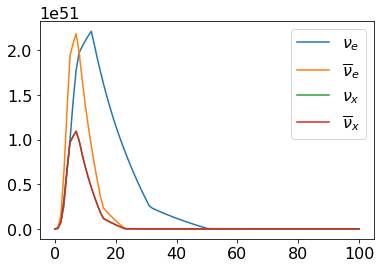

In [41]:
for flavor in Flavor:
    plt.plot(E, spectra[flavor], label=flavor.to_tex())
plt.legend()